# Rules Extraction

# Statics

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import Bunch
from sklearn.datasets._base import load_csv_data
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import csv

## Load Dataset

In [2]:
# Load Dataset
filename = 'clean_dataset'
target_true = '1'
target_false = '0'
test_size = 0.2


data_file_name = f'../../../data/{filename}.csv'
pandas_dataset = pd.read_csv(data_file_name)

target_value_name = pandas_dataset.columns[-1]
feature_names = pandas_dataset.columns[0:-1]

pandas_dataset.head()


,EMERGENCY_DIA_SHORT_F05,EMERGENCY_DIA_SHORT_J12,EMERGENCY_DIA_SHORT_R06,EMERGENCY_DIA_SHORT_K52,EMERGENCY_DIA_SHORT_I10,EMERGENCY_DIA_SHORT_J22,EMERGENCY_DIA_SHORT_J84,EMERGENCY_DIA_SHORT_E87,EMERGENCY_DIA_SHORT_R09,EMERGENCY_DIA_SHORT_J98,...,ANTECEDENTS_PROC_BW03ZZZ,ANTECEDENTS_PROC_0TPBX0Z,ANTECEDENTS_PROC_F0796FZ,ANTECEDENTS_PROC_4A12X4Z,ANTECEDENTS_PROC_3E03329,SEXO,AGE_LOWER_40,AGE_40_60,AGE_HIGHER_60,RESULT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0,0,0,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,0,0,1,1


# Divide dataset

In [3]:
X = pandas_dataset[feature_names]
y = pandas_dataset[target_value_name]

dataset = Bunch(
        data=X.to_numpy(),
        target=y.to_numpy(),
        target_names=target_value_name,
        feature_names=X.columns
)

#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print()
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')


Sizes (without target):
Original size (1744, 119)
Train size (1569, 119)
Test size (175, 119)


## Define Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100)
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


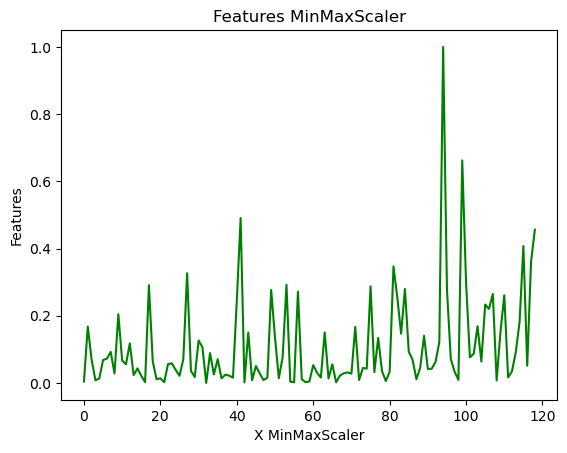

	 Original features 119
	 Selected features 63
	 Percentage of selected rules: 52.94117647058823 %
->Generate new tree based on list
Elapsed time to compute the binary_tree_generator: 225.182 seconds
->Generate obtained patterns tree
Elapsed time to compute the obtain_pattern_list_of_valid_nodes_with_pvalue: 0.803 seconds
->Categorize patterns
Elapsed time to compute the categorize_patterns: 0.360 seconds


In [10]:
from iPRules.iPRules import iPRules

rules = iPRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.97,
                scale_feature_coefficient = 0.05,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 2
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

# Print Model

In [11]:
# DISPLAY DESCRIPTION
print(rules.description())
# DISPLAY ALL RULES
#print(rules)

> ------------------------------
> iPRules (not ordered):
> Number of Rules 25:
> ------------------------------



# Predict

In [12]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [13]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble, normalize=True)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules, normalize=True)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')


DATASET TEST: 175
DATASET TEST categorizable: 173
Cobertura: 98.86%
RF accuracy: 81.50%
Rules Accuracy: 79.19%


# CONFUSION MATRIX

In [9]:

confusion_matrix = metrics.confusion_matrix(np_filterred_y_test, np_filterred_y_pred_test_rules)
print(confusion_matrix)
confusion_matrix(np_filterred_y_test, np_filterred_y_pred_test_rules, labels=dataset.feature_names)

[[135   0]
 [ 36   2]]


TypeError: 'numpy.ndarray' object is not callable

# SHAP explainer

In [ ]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)